<h2>Function for converting unicode symbols to ascii</h2>

In [1]:
ls /kaggle/input/multilingual-names/

Arabic.txt   English.txt  Irish.txt     Polish.txt      Spanish.txt
Chinese.txt  French.txt   Italian.txt   Portuguese.txt  Vietnamese.txt
Czech.txt    German.txt   Japanese.txt  Russian.txt
Dutch.txt    Greek.txt    Korean.txt    Scottish.txt


In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('/kaggle/input/multilingual-names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('/kaggle/input/multilingual-names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['/kaggle/input/multilingual-names/Vietnamese.txt', '/kaggle/input/multilingual-names/Greek.txt', '/kaggle/input/multilingual-names/Japanese.txt', '/kaggle/input/multilingual-names/Dutch.txt', '/kaggle/input/multilingual-names/Irish.txt', '/kaggle/input/multilingual-names/Russian.txt', '/kaggle/input/multilingual-names/Korean.txt', '/kaggle/input/multilingual-names/Scottish.txt', '/kaggle/input/multilingual-names/Czech.txt', '/kaggle/input/multilingual-names/Italian.txt', '/kaggle/input/multilingual-names/Arabic.txt', '/kaggle/input/multilingual-names/Portuguese.txt', '/kaggle/input/multilingual-names/Spanish.txt', '/kaggle/input/multilingual-names/Chinese.txt', '/kaggle/input/multilingual-names/French.txt', '/kaggle/input/multilingual-names/English.txt', '/kaggle/input/multilingual-names/German.txt', '/kaggle/input/multilingual-names/Polish.txt']
Slusarski


In [3]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [4]:
import torch.nn as nn
n_hidden = 128

In [5]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()

        self.hidden_size = hidden_size
        self.rnn = nn.LSTM(input_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, h, c):
        input = input.view(len(input), 1, -1)
        out, (h, c) = self.rnn(input, (h, c))
        output = self.out(out.view(len(input), -1))
        output = self.softmax(output)
        return output, h, c

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size), torch.zeros(1, 1, self.hidden_size)

In [7]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

In [8]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = German / line = Langer
category = Greek / line = Theohari
category = Spanish / line = Araujo
category = Russian / line = Jagovenko
category = German / line = Frost
category = Dutch / line = Tunison
category = Portuguese / line = Cabral
category = Spanish / line = Martinez
category = Irish / line = Colman
category = Chinese / line = Zhen


In [14]:
criterion = nn.NLLLoss()
learning_rate = 0.05

In [10]:
n_hidden = 128
rnn = LSTM(n_letters, n_hidden, n_categories)
print(rnn)

LSTM(
  (rnn): LSTM(57, 128)
  (out): Linear(in_features=128, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
)


In [11]:
def train(category_tensor, line_tensor):
    h, c = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, h, c = rnn(line_tensor[i], h, c)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()


In [12]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []
all_accurancy = []
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [15]:
start = time.time()
correct_num = 0
for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss
    
    guess, guess_i = categoryFromOutput(output)
    if guess == category:
        correct_num += 1
        
    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        all_accurancy.append(correct_num / plot_every)
        correct_num = 0

5000 5% (0m 17s) 1.5512 Kang / Korean ✗ (Chinese)
10000 10% (0m 34s) 1.8216 Cruz / Spanish ✗ (Portuguese)
15000 15% (0m 50s) 0.7963 Gutierrez / Spanish ✓
20000 20% (1m 6s) 0.0289 Christodoulou / Greek ✓
25000 25% (1m 23s) 2.3222 Strohkirch / Czech ✗ (German)
30000 30% (1m 40s) 0.5940 Cermak / Czech ✓
35000 35% (1m 57s) 0.9703 Ragno / Italian ✓
40000 40% (2m 14s) 0.0106 Hadjiyianakies / Greek ✓
45000 45% (2m 31s) 2.3106 Irwin / Scottish ✗ (English)
50000 50% (2m 47s) 0.0012 Haritopoulos / Greek ✓
55000 55% (3m 3s) 1.7607 Wolf / German ✗ (English)
60000 60% (3m 20s) 0.0312 Marchegiano / Italian ✓
65000 65% (3m 37s) 0.8124 Roma / Spanish ✓
70000 70% (3m 53s) 1.1627 Oldfield / German ✗ (English)
75000 75% (4m 9s) 0.1612 Svocak / Czech ✓
80000 80% (4m 26s) 0.1439 Shaw / Scottish ✓
85000 85% (4m 42s) 0.0013 Bahelov / Russian ✓
90000 90% (4m 59s) 0.0325 Donoghue / Irish ✓
95000 95% (5m 16s) 6.3610 Murtas / Scottish ✗ (Italian)
100000 100% (5m 32s) 0.8217 King / Scottish ✓


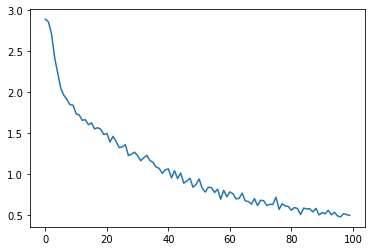

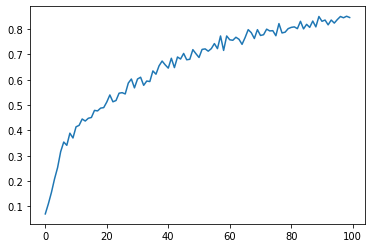

In [16]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

plt.figure()
plt.plot(all_accurancy)

In [17]:
class CustomLSTM(nn.Module):
    def __init__(self, input_sz, hidden_sz):
        super().__init__()
        self.input_sz = input_sz
        self.hidden_size = hidden_sz
        self.W = nn.Parameter(torch.Tensor(input_sz, hidden_sz * 4))
        self.U = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz * 4))
        self.bias = nn.Parameter(torch.Tensor(hidden_sz * 4))
        self.init_weights()
 
    def init_weights(self):
        stdv = 1.0 / math.sqrt(self.hidden_size)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv)
 
    def forward(self, x, 
                init_states=None):
        """Assumes x is of shape (batch, sequence, feature)"""
        bs, seq_sz, _ = x.size()
        hidden_seq = []
        if init_states is None:
            h_t, c_t = (torch.zeros(bs, self.hidden_size).to(x.device), 
                        torch.zeros(bs, self.hidden_size).to(x.device))
        else:
            h_t, c_t = init_states
 
        HS = self.hidden_size
        for t in range(seq_sz):
            x_t = x[:, t, :]
            # batch the computations into a single matrix multiplication
            gates = x_t @ self.W + h_t @ self.U + self.bias
            i_t, f_t, g_t, o_t = (
                torch.sigmoid(gates[:, :HS]), # input
                torch.sigmoid(gates[:, HS:HS*2]), # forget
                torch.tanh(gates[:, HS*2:HS*3]),
                torch.sigmoid(gates[:, HS*3:]), # output
            )
            c_t = f_t * c_t + i_t * g_t
            h_t = o_t * torch.tanh(c_t)
            hidden_seq.append(h_t.unsqueeze(0))
        hidden_seq = torch.cat(hidden_seq, dim=0)
        # reshape from shape (sequence, batch, feature) to (batch, sequence, feature)
        hidden_seq = hidden_seq.transpose(0, 1).contiguous()
        return hidden_seq, (h_t, c_t)

In [19]:
MODEL=CustomLSTM()

CustomLSTM()


In [26]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [6]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

In [7]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Russian / line = Velyashev
category = German / line = West
category = Czech / line = Marik
category = Dutch / line = Buiren
category = Vietnamese / line = Hoang
category = Korean / line = Chong
category = Spanish / line = Blanxart
category = Japanese / line = Oichi
category = Vietnamese / line = Huynh
category = Portuguese / line = Esteves


In [8]:
criterion = nn.NLLLoss()

In [59]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [31]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []
all_accurancy = []
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)



In [32]:
start = time.time()
correct_num = 0
for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss
    
    guess, guess_i = categoryFromOutput(output)
    if guess == category:
        correct_num += 1
        
    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        all_accurancy.append(correct_num / plot_every)
        correct_num = 0

5000 5% (0m 5s) 2.3377 Shin / Chinese ✗ (Korean)
10000 10% (0m 10s) 2.8738 Mata / Japanese ✗ (Portuguese)
15000 15% (0m 16s) 1.9475 Rosenfeld / Spanish ✗ (German)
20000 20% (0m 21s) 0.1371 Dubanowski / Polish ✓
25000 25% (0m 27s) 2.5881 Aller / German ✗ (Dutch)
30000 30% (0m 32s) 0.3024 Sabbag / Arabic ✓
35000 35% (0m 38s) 2.2255 Lewerentz / Spanish ✗ (German)
40000 40% (0m 43s) 0.1137 Son / Korean ✓
45000 45% (0m 48s) 0.1983 Divnov / Russian ✓
50000 50% (0m 54s) 1.5257 Blazek / Polish ✗ (Czech)
55000 55% (0m 59s) 0.4594 Yuasa / Japanese ✓
60000 60% (1m 5s) 0.5644 Baukin / Russian ✓
65000 65% (1m 10s) 0.1884 Trinh / Vietnamese ✓
70000 70% (1m 15s) 1.5154 Pena / Chinese ✗ (Spanish)
75000 75% (1m 21s) 0.4837 Belinskij / Russian ✓
80000 80% (1m 26s) 0.0566 Panayiotopoulos / Greek ✓
85000 85% (1m 32s) 0.4440 Gonzalez / Spanish ✓
90000 90% (1m 37s) 1.9321 Vigo / Spanish ✗ (Italian)
95000 95% (1m 43s) 3.7410 Swango / Korean ✗ (German)
100000 100% (1m 48s) 1.1805 Loritz / Spanish ✗ (German)


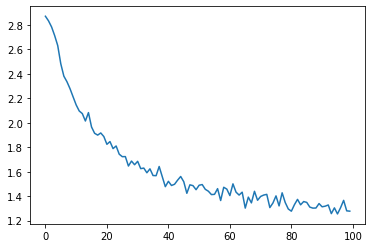

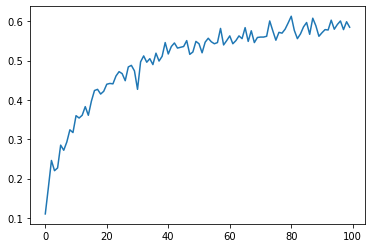

In [33]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

plt.figure()
plt.plot(all_accurancy)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator


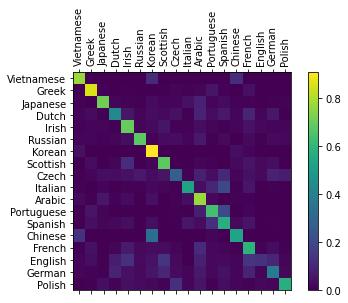

In [34]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [66]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=2)
        self.linear = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        # print(input_size)

    def forward(self, x):
        out, (h_n, c_n) = self.lstm(x)
        out = (self.linear(out[-1]))
        out = self.softmax(out)
        return out

In [67]:
rnn = LSTM(n_letters, n_hidden, n_categories)
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.005)

In [68]:
print(rnn)

LSTM(
  (lstm): LSTM(57, 128, num_layers=2)
  (linear): Linear(in_features=128, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
)


In [69]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []
all_accurancy = []
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


In [70]:

def train(category_tensor, line_tensor):
    optimizer.zero_grad()
    output = rnn(line_tensor)
    loss = criterion(output, category_tensor)
    loss.backward()
    optimizer.step()
    return output, loss.item()


In [71]:
start = time.time()
correct_num = 0
for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss
    
    guess, guess_i = categoryFromOutput(output)
    if guess == category:
        correct_num += 1
        
    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        all_accurancy.append(correct_num / plot_every)
        correct_num = 0

5000 5% (0m 19s) 0.7481 Herrera / Spanish ✓
10000 10% (0m 38s) 0.0832 Ma / Korean ✓
15000 15% (0m 58s) 0.1768 Cermak / Czech ✓
20000 20% (1m 18s) 1.3683 Tatsuno / Italian ✗ (Japanese)
25000 25% (1m 37s) 0.0012 Sayegh / Arabic ✓
30000 30% (1m 56s) 0.0002 Papadopulos / Greek ✓
35000 35% (2m 15s) 0.0037 Deeb / Arabic ✓
40000 40% (2m 35s) 0.5732 Shirane / Japanese ✓
45000 45% (2m 54s) 0.0000 Kieu / Vietnamese ✓
50000 50% (3m 13s) 0.0005 Bekhtenev / Russian ✓
55000 55% (3m 33s) 0.2860 Hanzlick / Czech ✓
60000 60% (3m 52s) 2.5942 Names / English ✗ (Irish)
65000 65% (4m 11s) 0.6657 Edley / English ✓
70000 70% (4m 31s) 1.1131 Mata / Spanish ✗ (Portuguese)
75000 75% (4m 51s) 3.2568 Rios / Portuguese ✗ (Spanish)
80000 80% (5m 10s) 0.0000 O'Doherty / Irish ✓
85000 85% (5m 30s) 0.0475 Seok / Korean ✓
90000 90% (5m 49s) 0.0648 Vavra / Czech ✓
95000 95% (6m 9s) 0.0962 Czabal / Czech ✓
100000 100% (6m 29s) 0.0085 Vazhenin / Russian ✓


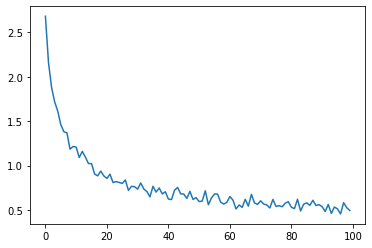

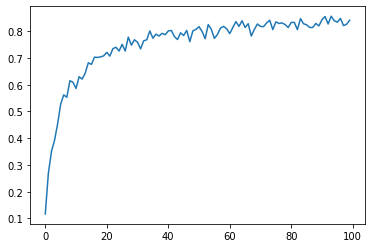

In [73]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

plt.figure()
plt.plot(all_accurancy)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator


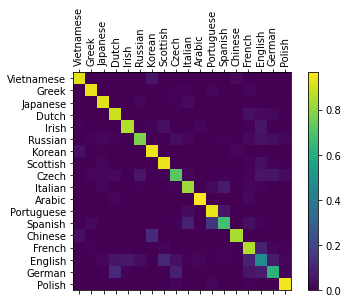

In [74]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    output = rnn(line_tensor)
    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()


# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()